# Fingerprints pipeline (ECFP4)

This section prepares an RDKit environment, loads DrugBank SMILES, generates 2048-bit Morgan fingerprints (ECFP4), and saves outputs for downstream modeling and visualization.


In [25]:
!python --version # Quick Check

Python 3.11.13


## Python and RDKit environment

Two workable routes are shown:

- **System Python 3.11 via `apt`** → set as the default interpreter.
- **Micromamba environment (recommended in Colab)** → creates an isolated env `rdkit311` with RDKit from `conda-forge`.

The micromamba route keeps dependencies clean and avoids conflicts with the base runtime.


In [26]:
# Install Python 3.11 and set it as default
!sudo apt-get update -y
!sudo apt-get install -y python3.11 python3.11-dev python3.11-distutils

# Point `python3` to Python 3.11
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.11 2
!sudo update-alternatives --config python3
2

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

2

In [27]:
!python --version




Python 3.11.13


In [28]:
# Install micromamba
!wget -qO /tmp/micromamba.tar.bz2 https://micro.mamba.pm/api/micromamba/linux-64/latest
!tar -xjf /tmp/micromamba.tar.bz2 -C /usr/local bin/micromamba

# Create Python 3.11 env with RDKit from conda-forge
!/usr/local/bin/micromamba create -y -n rdkit311 -c conda-forge python=3.11 rdkit


conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache
[+] 0.0s


Transaction

  Prefix: /root/.local/share/mamba/envs/rdkit311

  Updating specs:

   - python=3.11
   - rdkit


  Package                           Version  Build                 Channel           Size
───────────────────────────────────────────────────────────────────────────────────────────
  Install:
───────────────────────────────────────────────────────────────────────────────────────────

  + _libgcc_mutex                       0.1  conda_forge           conda-forge     Cached
  + _openmp_mutex                       4.5  2_gnu                 conda-forge     Cached
  + brotli                            1.1.0  hb03c661_4            conda-forge     Cached
  + brotli-bin                        1.1.0  hb03c661_4            conda-forge     Cached
  + bzip2                             1.0.8  h4bc722e_7            conda-forge     Cach

## RDKit smoke test

A short check confirms:
- Python and RDKit versions
- Fingerprint creation works (Morgan/ECFP)
- Bit length and number of “on-bits” look sensible

If this fails, the environment wasn’t set correctly.



In [29]:
%%bash
/usr/local/bin/micromamba run -n rdkit311 python - <<'PY'
import sys, rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

print("Python:", sys.version)
print("RDKit version:", rdkit.__version__)

mol = Chem.MolFromSmiles("CCO")
fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)
print("Fingerprint bits:", fp.GetNumBits(), "on-bits:", fp.GetNumOnBits())
PY


Python: 3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:48:23) [GCC 13.3.0]
RDKit version: 2025.03.6
Fingerprint bits: 1024 on-bits: 6


[16:33:08] DEPRECATION WARNING: please use MorganGenerator


In [30]:
!/usr/local/bin/micromamba run -n rdkit311 python -m pip install ipykernel
!/usr/local/bin/micromamba run -n rdkit311 python -m ipykernel install --user --name rdkit311 --display-name "Python 3.11 (RDKit)"


  Using cached ipykernel-6.30.1-py3-none-any.whl.metadata (6.2 kB)
  Using cached comm-0.2.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached debugpy-1.8.16-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.3 kB)
  Using cached ipython-9.5.0-py3-none-any.whl.metadata (4.4 kB)
  Using cached jupyter_client-8.6.3-py3-none-any.whl.metadata (8.3 kB)
  Using cached jupyter_core-5.8.1-py3-none-any.whl.metadata (1.6 kB)
  Using cached matplotlib_inline-0.1.7-py3-none-any.whl.metadata (3.9 kB)
  Using cached nest_asyncio-1.6.0-py3-none-any.whl.metadata (2.8 kB)
  Using cached psutil-7.0.0-cp36-abi3-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (22 kB)
  Using cached pyzmq-27.0.2-cp311-cp311-manylinux_2_26_x86_64.manylinux_2_28_x86_64.whl.metadata (6.0 kB)
  Using cached tornado-6.5.2-cp39-abi3-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.met

## Convenience: `%%rdkit` cell magic

A small helper runs any cell **inside** the `rdkit311` environment.  
Usage: start the cell with `%%rdkit` and write normal Python. Helpful when mixing Colab’s base kernel with RDKit work.


In [31]:
# System/Jupyter helpers (used by the %%rdkit cell magic)
import subprocess      # run external commands
import tempfile        # create temporary files
import textwrap        # clean up multiline strings
from IPython.core.magic import register_cell_magic  # define custom cell magics

# Data and numerics
import pandas as pd    # tabular data
import numpy as np     # arrays and math

# Colab I/O
from google.colab import files  # save/download files from the notebook

# Plotting
import matplotlib.pyplot as plt  # figures

# Dimensionality reduction / preprocessing
from sklearn.decomposition import PCA, TruncatedSVD  # linear pre-reduction (dense/sparse)
from sklearn.manifold import TSNE                    # t-SNE 2D mapping
from sklearn.preprocessing import StandardScaler     # feature scaling for PCA
from scipy.sparse import issparse                    # check if matrix is sparse
import umap                                          # UMAP 2D mapping


In [32]:
# Run this once per runtime
# execute in the 'rdkit311' micromamba environment.
@register_cell_magic
def rdkit(line, cell):
    code = textwrap.dedent(cell)
    with tempfile.NamedTemporaryFile('w', suffix='.py', delete=False) as f:
        f.write(code)
        path = f.name
    # Execute in the micromamba env
    result = subprocess.run(
        ["/usr/local/bin/micromamba", "run", "-n", "rdkit311", "python", path],
        capture_output=True, text=True
    )
    # Stream outputs
    if result.stdout:
        print(result.stdout, end="")
    if result.stderr:
        # Show RDKit warnings but not as a failure
        print(result.stderr, end="")
    if result.returncode != 0:
        raise RuntimeError(f"rdkit311 execution failed with code {result.returncode}")


In [33]:
%%rdkit
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator as rfg

mol = Chem.MolFromSmiles("CCO")
gen = rfg.GetMorganGenerator(radius=2, fpSize=1024)  # factory function
fp  = gen.GetFingerprint(mol)

print("Bits:", fp.GetNumBits(), "On-bits:", fp.GetNumOnBits())


Bits: 1024 On-bits: 6


## Load metadata and labels

- Read `drugbank_smiles_final.csv` from Drive.
- Expect a `SMILES` column and a downstream `Label` column created earlier from ATC codes.
- Only the `SMILES` column is passed to RDKit for fingerprinting; labels stay in the main kernel.


In [34]:
import pandas as pd
import numpy as np

In [35]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [36]:
smiles_path= '/content/drive/My Drive/drugbank_smiles_final.csv'

print("Loaded from Google Drive!")

Loaded from Google Drive!


In [37]:
# Load your data
df = pd.read_csv('/content/drive/My Drive/drugbank_smiles_final.csv')

# Check if 'SMILES' column exists
print(df.columns)


Index(['DrugBankID', 'Name', 'SMILES', 'ATC_Codes', 'Label'], dtype='object')


In [38]:
# Save just the SMILES column for RDKit to read
assert 'SMILES' in df.columns, "df must have a 'SMILES' column"
df[['SMILES']].to_csv('/content/smiles.csv', index=False)


## Generate ECFP4 fingerprints

Settings used:
- **Radius = 2** → ECFP4 (captures environments up to two bonds away).
- **fpSize = 2048** → common bit length; balances collision risk and file size.

Process:
1. Parse each SMILES to an RDKit molecule.
2. Compute the Morgan bit vector.
3. Convert to a NumPy row.
4. Track indices that fail to parse (`bad_idx.csv`) so rows can be reviewed later.

Output files:
- `/content/bad_idx.csv` → zero or more problematic rows


In [39]:
%%rdkit
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator as rfg
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray

# Read the SMILES
df_sm = pd.read_csv('/content/smiles.csv')

n_bits = 2048
gen = rfg.GetMorganGenerator(radius=2, fpSize=n_bits)  # ECFP4

X = np.zeros((len(df_sm), n_bits), dtype=np.uint8)
bad_idx = []

for i, smi in enumerate(df_sm['SMILES'].astype(str)):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        bad_idx.append(i)
        continue
    arr = np.zeros((n_bits,), dtype=np.uint8)
    fp = gen.GetFingerprint(mol)
    ConvertToNumpyArray(fp, arr)
    X[i] = arr

# Save outputs for the main kernel
np.save('/content/ecfp4_2048.npy', X)
pd.Series(bad_idx, name='bad_idx').to_csv('/content/bad_idx.csv', index=False)
print("Done:", X.shape, "bad:", len(bad_idx))

Done: (12306, 2048) bad: 10
[16:33:28] Explicit valence for atom # 13 Cl, 5, is greater than permitted
[16:33:28] SMILES Parse Error: syntax error while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[16:33:28] SMILES Parse Error: check for mistakes around position 84:
[16:33:28] C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O
[16:33:28] ~~~~~~~~~~~~~~~~~~~~^
[16:33:28] SMILES Parse Error: extra open parentheses while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2=N/C(/C=C2)=C(\C2=CC=C\-1N2)C1=CC=C(C=C1)S(O)(O)O)C1=CC=C(C=C1)S([O-])([O-])[O-])\C1=CC=C(C=C1)S(O)(O)[O-]
[16:33:28] SMILES Parse Error: check for mistakes around position 40:
[16:33:28] 1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)=C(/C2
[16:33:28] ~~~~~~~~~~~~~~~~~~~~^
[16:33:28] SMILES Parse Error: extra open parentheses while parsing: OS(O)(O)C1=CC=C(C=C1)C-1=C2\C=CC(=N2)\C(=C2/N\C(\C=C2)

## Join back to metadata and save

- Combine the `(n, 2048)` bit matrix with the original dataframe.
- Columns are named `fp_0 … fp_2047`.
- Save the merged table to Drive as `ecfp_final.csv`.  
This is the table used for modeling, t-SNE/UMAP, and metric reporting.


In [40]:
X = np.load('/content/ecfp4_2048.npy')
ecfp_df = pd.DataFrame(X, columns=[f'fp_{i}' for i in range(X.shape[1])])

# Re-align and concat
df_with_fp = pd.concat([df.reset_index(drop=True), ecfp_df], axis=1)


In [41]:
# Save fingerprints with metadata 2
df_with_fp.to_csv('/content/drive/My Drive/ecfp_final.csv', index=False)



In [42]:
# Save CSV and download it
df_with_fp.to_csv('ecfp_final.csv', index=False)
files.download('ecfp_final.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### t-SNE on fingerprints

- Input: binary ECFP4 matrix `(n × 2048)`.  
- Pre-reduction: **TruncatedSVD → 50 components** to stabilize t-SNE on high-dimensional sparse bits.  
- t-SNE settings: `perplexity=30`, `learning_rate=200`, `n_iter=1000`, `init="pca"`, `metric="euclidean"`, `random_state=42`.  
- Rationale: SVD handles sparsity; Euclidean after SVD is a robust default for t-SNE.


In [43]:
# Helper to plot 2D embeddings
def plot_2d(emb2d, labels, title="2D projection", palette=None, s=10):
    emb2d = np.asarray(emb2d)
    labels = np.asarray(labels)
    fig, ax = plt.subplots(figsize=(6.5, 5.5), dpi=130)
    classes = pd.Series(labels).astype(str).values
    uniq = pd.unique(classes)
    for c in uniq:
        m = classes == c
        ax.scatter(emb2d[m, 0], emb2d[m, 1], s=s, alpha=0.8, label=str(c))
    ax.set_title(title)
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")
    ax.legend(markerscale=1.5, bbox_to_anchor=(1.04, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12306 samples in 0.002s...
[t-SNE] Computed neighbors for 12306 samples in 1.748s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12306
[t-SNE] Computed conditional probabilities for sample 2000 / 12306
[t-SNE] Computed conditional probabilities for sample 3000 / 12306
[t-SNE] Computed conditional probabilities for sample 4000 / 12306
[t-SNE] Computed conditional probabilities for sample 5000 / 12306
[t-SNE] Computed conditional probabilities for sample 6000 / 12306
[t-SNE] Computed conditional probabilities for sample 7000 / 12306
[t-SNE] Computed conditional probabilities for sample 8000 / 12306
[t-SNE] Computed conditional probabilities for sample 9000 / 12306
[t-SNE] Computed conditional probabilities for sample 10000 / 12306
[t-SNE] Computed conditional probabilities for sample 11000 / 12306
[t-SNE] Computed conditional probabilities for sample 12000 / 12306
[t-SNE] Computed conditional probabilities for sam

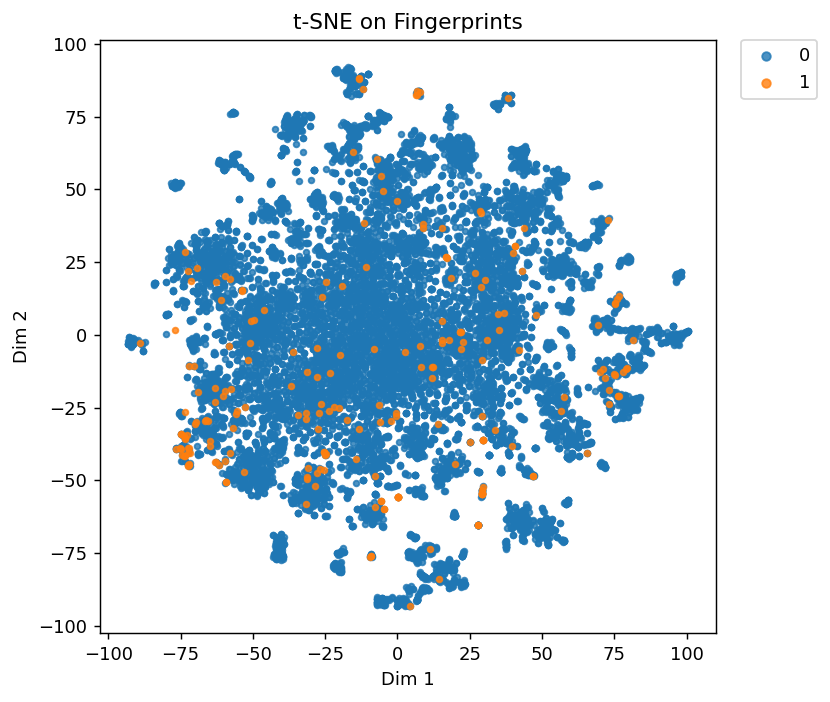

In [24]:
# Use the fingerprint data from the variable X and labels from df_with_fp
X_fps = X
y = df_with_fp['Label']

# Pre-reduce to 50D for speed/stability
X50 = linear_reduce(X_fps, n_components=50, random_state=42)

# t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=30,        # try 10, 30, 50 for different local/global structure
    learning_rate=200,
    n_iter=1000,
    init="pca",
    random_state=42,
    metric="euclidean",   # robust choice after linear reduction
    verbose=1
)
Z_tsne = tsne.fit_transform(X50)

# Plot
plot_2d(Z_tsne, y, title="t-SNE on Fingerprints")

### UMAP on fingerprints

- Input: the same ECFP4 matrix `(n × 2048)` (binary).  
- Metric: **Jaccard** (set overlap) is used for 0/1 fingerprints; no scaling or SVD required.  
- UMAP settings: `n_neighbors=30`, `min_dist=0.1`, `metric="jaccard"`, `random_state=42`.  
- Rationale: Jaccard reflects bit overlap directly; `n_neighbors` controls local vs global structure, `min_dist` controls cluster tightness.


In [44]:
def linear_reduce(X, n_components, random_state):
    """
    Performs linear dimensionality reduction using PCA or TruncatedSVD.

    Args:
        X: Input data (dense or sparse).
        n_components: The number of components to keep.
        random_state: Random state for reproducibility.

    Returns:
        Reduced data.
    """
    if issparse(X):
        reducer = TruncatedSVD(n_components=n_components, random_state=random_state)
    else:
        reducer = PCA(n_components=n_components, random_state=random_state)
        # It is often beneficial to scale dense data before PCA
        X = StandardScaler().fit_transform(X)

    return reducer.fit_transform(X)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/pynndescent/pynndescent_.py:939: UserWarning: Failed to correctly find n_neighbors for some samples. Results may be less than ideal. Try re-running with different parameters.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:127: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 1352 edges.
It has only fully disconnected 22 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


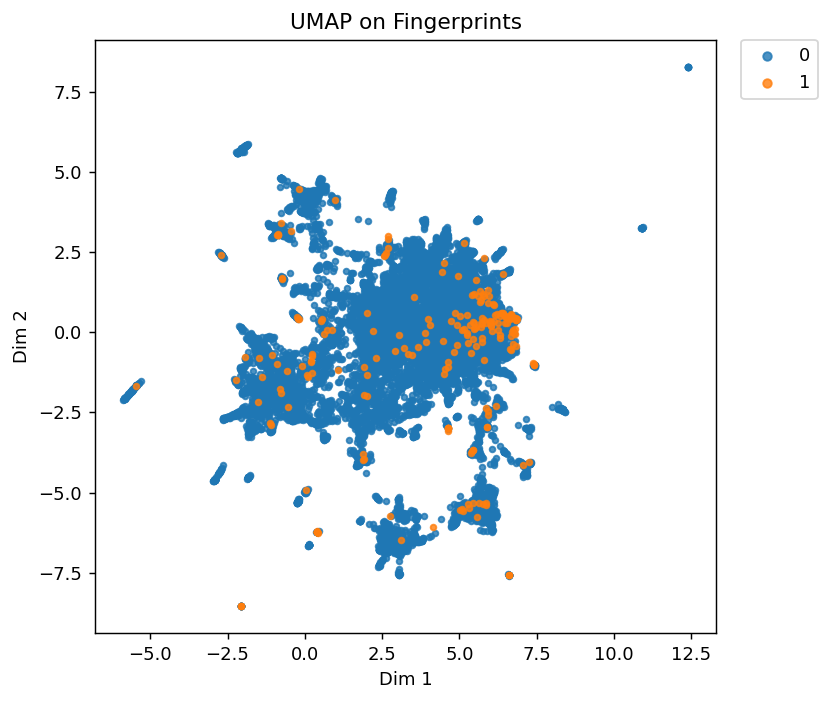

In [23]:
# Choose a metric that fits your data type
# Binary fingerprints (0/1, often sparse): "jaccard" or "hamming"
# Real-valued/dense fingerprints: "cosine" is usually strong
metric = "jaccard"  # change to "cosine" if your X_fps is not strictly binary

X_fps = X # Assign the fingerprint data from X to X_fps

umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,        # 0.0 (tighter clusters) to 0.5 (more spread)
    n_components=2,
    metric=metric,
    random_state=42
)
Z_umap = umap_model.fit_transform(X_fps)  # can pass sparse directly

plot_2d(Z_umap, y, title=f"UMAP on Fingerprints")